## 1 Libraries

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.cluster import KMeans
from sklearn.inspection import PartialDependenceDisplay
from sklearn.ensemble import RandomForestRegressor

In [2]:
data = pd.read_csv('Assignment.csv')
data.head()

,AGEPH,CODPOSS,duree,lnexpo,nbrtotc,nbrtotan,chargtot,agecar,sexp,fuelc,split,usec,fleetc,sportc,coverp,powerc
0,64,1000,1.000000,0.000000,0,0.000000,0.000000,2-5,Female,Petrol,Once,Private,No,No,MTPL+,66-110
1,28,1000,0.046575,-3.066684,1,21.470588,155.974606,6-10,Female,Petrol,Twice,Private,No,No,MTPL,66-110
2,58,1000,0.402740,-0.909465,0,0.000000,0.000000,>10,Female,Petrol,Thrice,Private,No,No,MTPL,<66
3,37,1030,0.169863,-1.772763,0,0.000000,0.000000,2-5,Female,Petrol,Once,Professional,No,No,MTPL+++,66-110
4,29,1030,1.000000,0.000000,0,0.000000,0.000000,6-10,Female,Petrol,Once,Private,No,No,MTPL+,<66


## 2 Feature engineering

In this section:
* categorical covariates will be mapped
* tranformation of zipcode data to categorical using k nearest neigbours

### 2.1 Mapping text columns to categorical

The mapping is made to a signle column, and not to a vector, because all the string columns have internal ordering structure.

In [3]:
data['agecar'] =  data['agecar'].map({'0-1': 0, '2-5': 1, '6-10': 2, '>10': 3}) 
data['sexp'] =  data['sexp'].map({'Female': 0, 'Male':1}) 
data['fuelc'] = data['fuelc'].map({'Petrol': 0, 'Gasoil': 1})
data['split'] = data['split'].map({'Once': 0, 'Twice': 1, 'Thrice': 2, 'Monthly': 3})
data['usec'] = data['usec'].map({'Private': 0, 'Professional': 1})
data['fleetc'] = data['fleetc'].map({'No': 0, 'Yes': 1})
data['sportc'] = data['sportc'].map({'No': 0, 'Yes': 1})
data['coverp'] = data['coverp'].map({'MTPL': 0, 'MTPL+': 1, 'MTPL+++': 2})
data['powerc'] = data['powerc'].map({'<66': 0, '66-110': 1, '>110': 2})

### 2.2 Transforming exposure

In [4]:
data['expo'] =  data['lnexpo'].apply(np.exp)

### 2.3 Handling postal code

In [5]:
geo_data =  pd.read_excel('inspost.xls')
df1 = data[['CODPOSS']]
df2 = geo_data[['CODPOSS', 'LAT', 'LONG']]
mapped_geodata = pd.merge(df1, df2, on='CODPOSS', how='left')

mapped_geodata.head()

,CODPOSS,LAT,LONG
0,1000,50.833333,4.350000
1,1000,50.833333,4.350000
2,1000,50.833333,4.350000
3,1030,50.850000,4.383333
4,1030,50.850000,4.383333


#### 2.3.1 Clustering of the datapoints

The idea is to divide the data into categories, which a close in location (LAT and LONG) and in loss per exposure. 

Since the categories can't be ordered, one-hot encoding approach is used to transform the clusters intor vectors

In [6]:
clustering_df = pd.DataFrame({
    'LAT': mapped_geodata['LAT'],
    'LONG': mapped_geodata['LONG'],
    'loss': data['chargtot'] / data['expo'] # Proxy to the technical premium
})

X_scaled = StandardScaler().fit_transform(clustering_df[['LAT', 'LONG', 'loss']])

N_CLUSTERS = 4
kmeans = KMeans(n_clusters=N_CLUSTERS)
kmeans.fit(X_scaled)

ONE_HOT_PREFIX = 'loc_category'
ONE_HOT_SEP = '_'
one_hot = pd.get_dummies(kmeans.labels_, prefix=ONE_HOT_PREFIX, prefix_sep=ONE_HOT_SEP)

data = pd.concat([data, one_hot], axis=1)


C:\Users\seidm\anaconda3\envs\dsei\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [7]:
data

,AGEPH,CODPOSS,duree,lnexpo,nbrtotc,nbrtotan,chargtot,agecar,sexp,fuelc,...,usec,fleetc,sportc,coverp,powerc,expo,loc_category_0,loc_category_1,loc_category_2,loc_category_3
0,64,1000,1.000000,0.000000,0,0.000000,0.000000,1,0,0,...,0,0,0,1,1,1.000000,0,0,0,1
1,28,1000,0.046575,-3.066684,1,21.470588,155.974606,2,0,0,...,0,0,0,0,1,0.046575,0,0,0,1
2,58,1000,0.402740,-0.909465,0,0.000000,0.000000,3,0,0,...,0,0,0,0,0,0.402740,0,0,0,1
3,37,1030,0.169863,-1.772763,0,0.000000,0.000000,1,0,0,...,1,0,0,2,1,0.169863,0,0,0,1
4,29,1030,1.000000,0.000000,0,0.000000,0.000000,2,0,0,...,0,0,0,1,0,1.000000,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163652,50,9960,1.000000,0.000000,0,0.000000,0.000000,1,1,0,...,0,0,0,1,0,1.000000,0,0,0,1
163653,86,9960,1.000000,0.000000,0,0.000000,0.000000,2,1,0,...,0,0,0,0,0,1.000000,0,0,0,1
163654,64,9960,1.000000,0.000000,0,0.000000,0.000000,1,1,0,...,0,0,0,0,0,1.000000,0,0,0,1
163655,58,9970,1.000000,0.000000,1,1.000000,3177.994988,3,1,0,...,0,1,0,0,0,1.000000,0,0,0,1


### 2.4 Feature columns

In [8]:
feat_cols = ['agecar','sexp','fuelc','split','usec','fleetc','sportc','coverp', 'powerc', 'AGEPH'] + [
    f'{ONE_HOT_PREFIX}{ONE_HOT_SEP}{i}' for i in range(N_CLUSTERS)
]

categorical_feat_cols = list(set(feat_cols) - set(['AGEPH']))

### 2.5 Train-test split

To avoid disbalance in the data the split was stratified to $nbrtotc>0$. 

In [9]:
X = data[feat_cols].copy()
#X['claims_pistive'] = data['nbrtotc'] > 0
y = data[['nbrtotc', 'chargtot', 'expo']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=data['nbrtotc'] > 0, random_state=42)

## 3 XGBoost

In [10]:
def get_feat_importance(tree_based_alg, X):

    # Get the feature importances
    importances = tree_based_alg.feature_importances_

    # Create a dataframe to store the feature importances
    feature_importances = pd.DataFrame({'feature': X.columns, 'importance': importances})

    # Sort the dataframe by importance
    feature_importances = feature_importances.sort_values(by='importance', ascending=False)


    plt.figure(figsize=(10, 6))

    # Plot the feature importances
    plt.bar(feature_importances['feature'], feature_importances['importance'])
    plt.xticks(rotation=90)
    plt.xlabel('Feature')
    plt.ylabel('Importance')
    plt.title('Feature Importance')
    plt.show()
    
    return pd.DataFrame(
        {
            'feature':tree_based_alg.feature_names_in_, 
            'importance':tree_based_alg.feature_importances_
        }
    ).sort_values('importance', ascending=False)

### 3.1 Frequency prediction

In [11]:
X_freq_train = X_train.copy()
y_freq_train = y_train['nbrtotc'] / y_train['expo']
w_freq_train = y_train['expo']

#### 3.1.1 Mode building

In [12]:
param_dict_xgb = {'max_depth' : [1, 3, 5, 7, 9],
              'n_estimators' : [100, 200, 300],
              'colsample_bynode' : [0.5, 0.75, 1],
              'lambda' : [0, 0.1, 1],
              'alpha' : [0, 0.1, 1]}

xgb_init_freq = xgb.XGBRegressor(booster='gbtree',
                            learning_rate = 0.01,
                            objective='count:poisson',
                            eval_metric = 'poisson-nloglik',
                            monotone_constraints = (1,0,0,0,0,0,0,0,0),
                            base_score = np.sum(y_freq_train * w_freq_train)/np.sum(w_freq_train))

In [13]:
%time 

xgb_randomsearch_freq = RandomizedSearchCV(estimator=xgb_init_freq,
                                      param_distributions=param_dict_xgb,
                                      scoring='neg_mean_poisson_deviance',
                                      n_iter=2,
                                      verbose=1,
                                      cv=5,
                                      random_state = 54321)
xgb_randomsearch_freq.fit(X_freq_train, y_freq_train, sample_weight=w_freq_train)

CPU times: total: 0 ns
Wall time: 0 ns
Fitting 5 folds for each of 2 candidates, totalling 10 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=0.13944292879289957,
                                          booster='gbtree', callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric='poisson-nloglik',
                                          feature_types=None, gamma=None,
                                          gpu_id=None, grow_policy=None,
                                          importance_type=None,
                                          interaction...
                                          monotone_constraints=(1, 0, 0, 0, 0,
                                                                0, 0, 0, 0),
                                          n_estimators=100, n_jobs=None,
                                          num_parallel_tree=None,
                                          objective='count:poisson',
                                          predictor=None, ...),
                   n_iter=2,
                   param_distributions={'alpha': [0, 0.1, 1],
                                        'colsample_bynode': [0.5, 0.75, 1],
                                        'lambda': [0, 0.1, 1],
                                        'max_depth': [1, 3, 5, 7, 9],
                                        'n_estimators': [100, 200, 300]},
                   random_state=54321, scoring='neg_mean_poisson_deviance',
                   verbose=1)

In [14]:
xgb_freq = xgb_randomsearch_freq.best_estimator_

#### 3.1.2 Interpretation

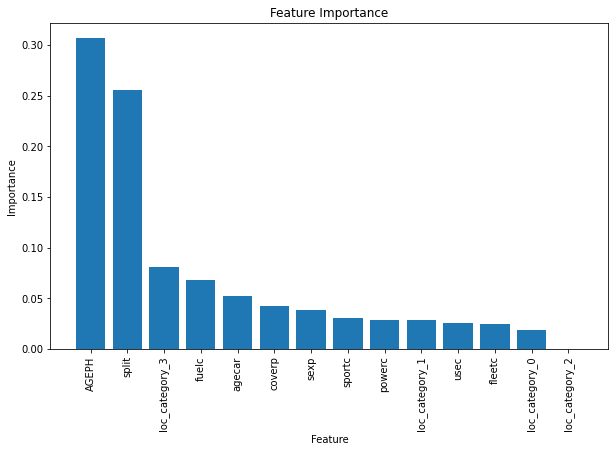

,feature,importance
9,AGEPH,0.306604
3,split,0.255346
13,loc_category_3,0.080636
2,fuelc,0.068193
0,agecar,0.051908
7,coverp,0.042103
1,sexp,0.038943
6,sportc,0.030366
8,powerc,0.028539
11,loc_category_1,0.028254


In [15]:
get_feat_importance(xgb_freq, X_freq_train)

In [16]:
plt.figure(figsize=(50, 40))

<Figure size 3600x2880 with 0 Axes>

<Figure size 3600x2880 with 0 Axes>

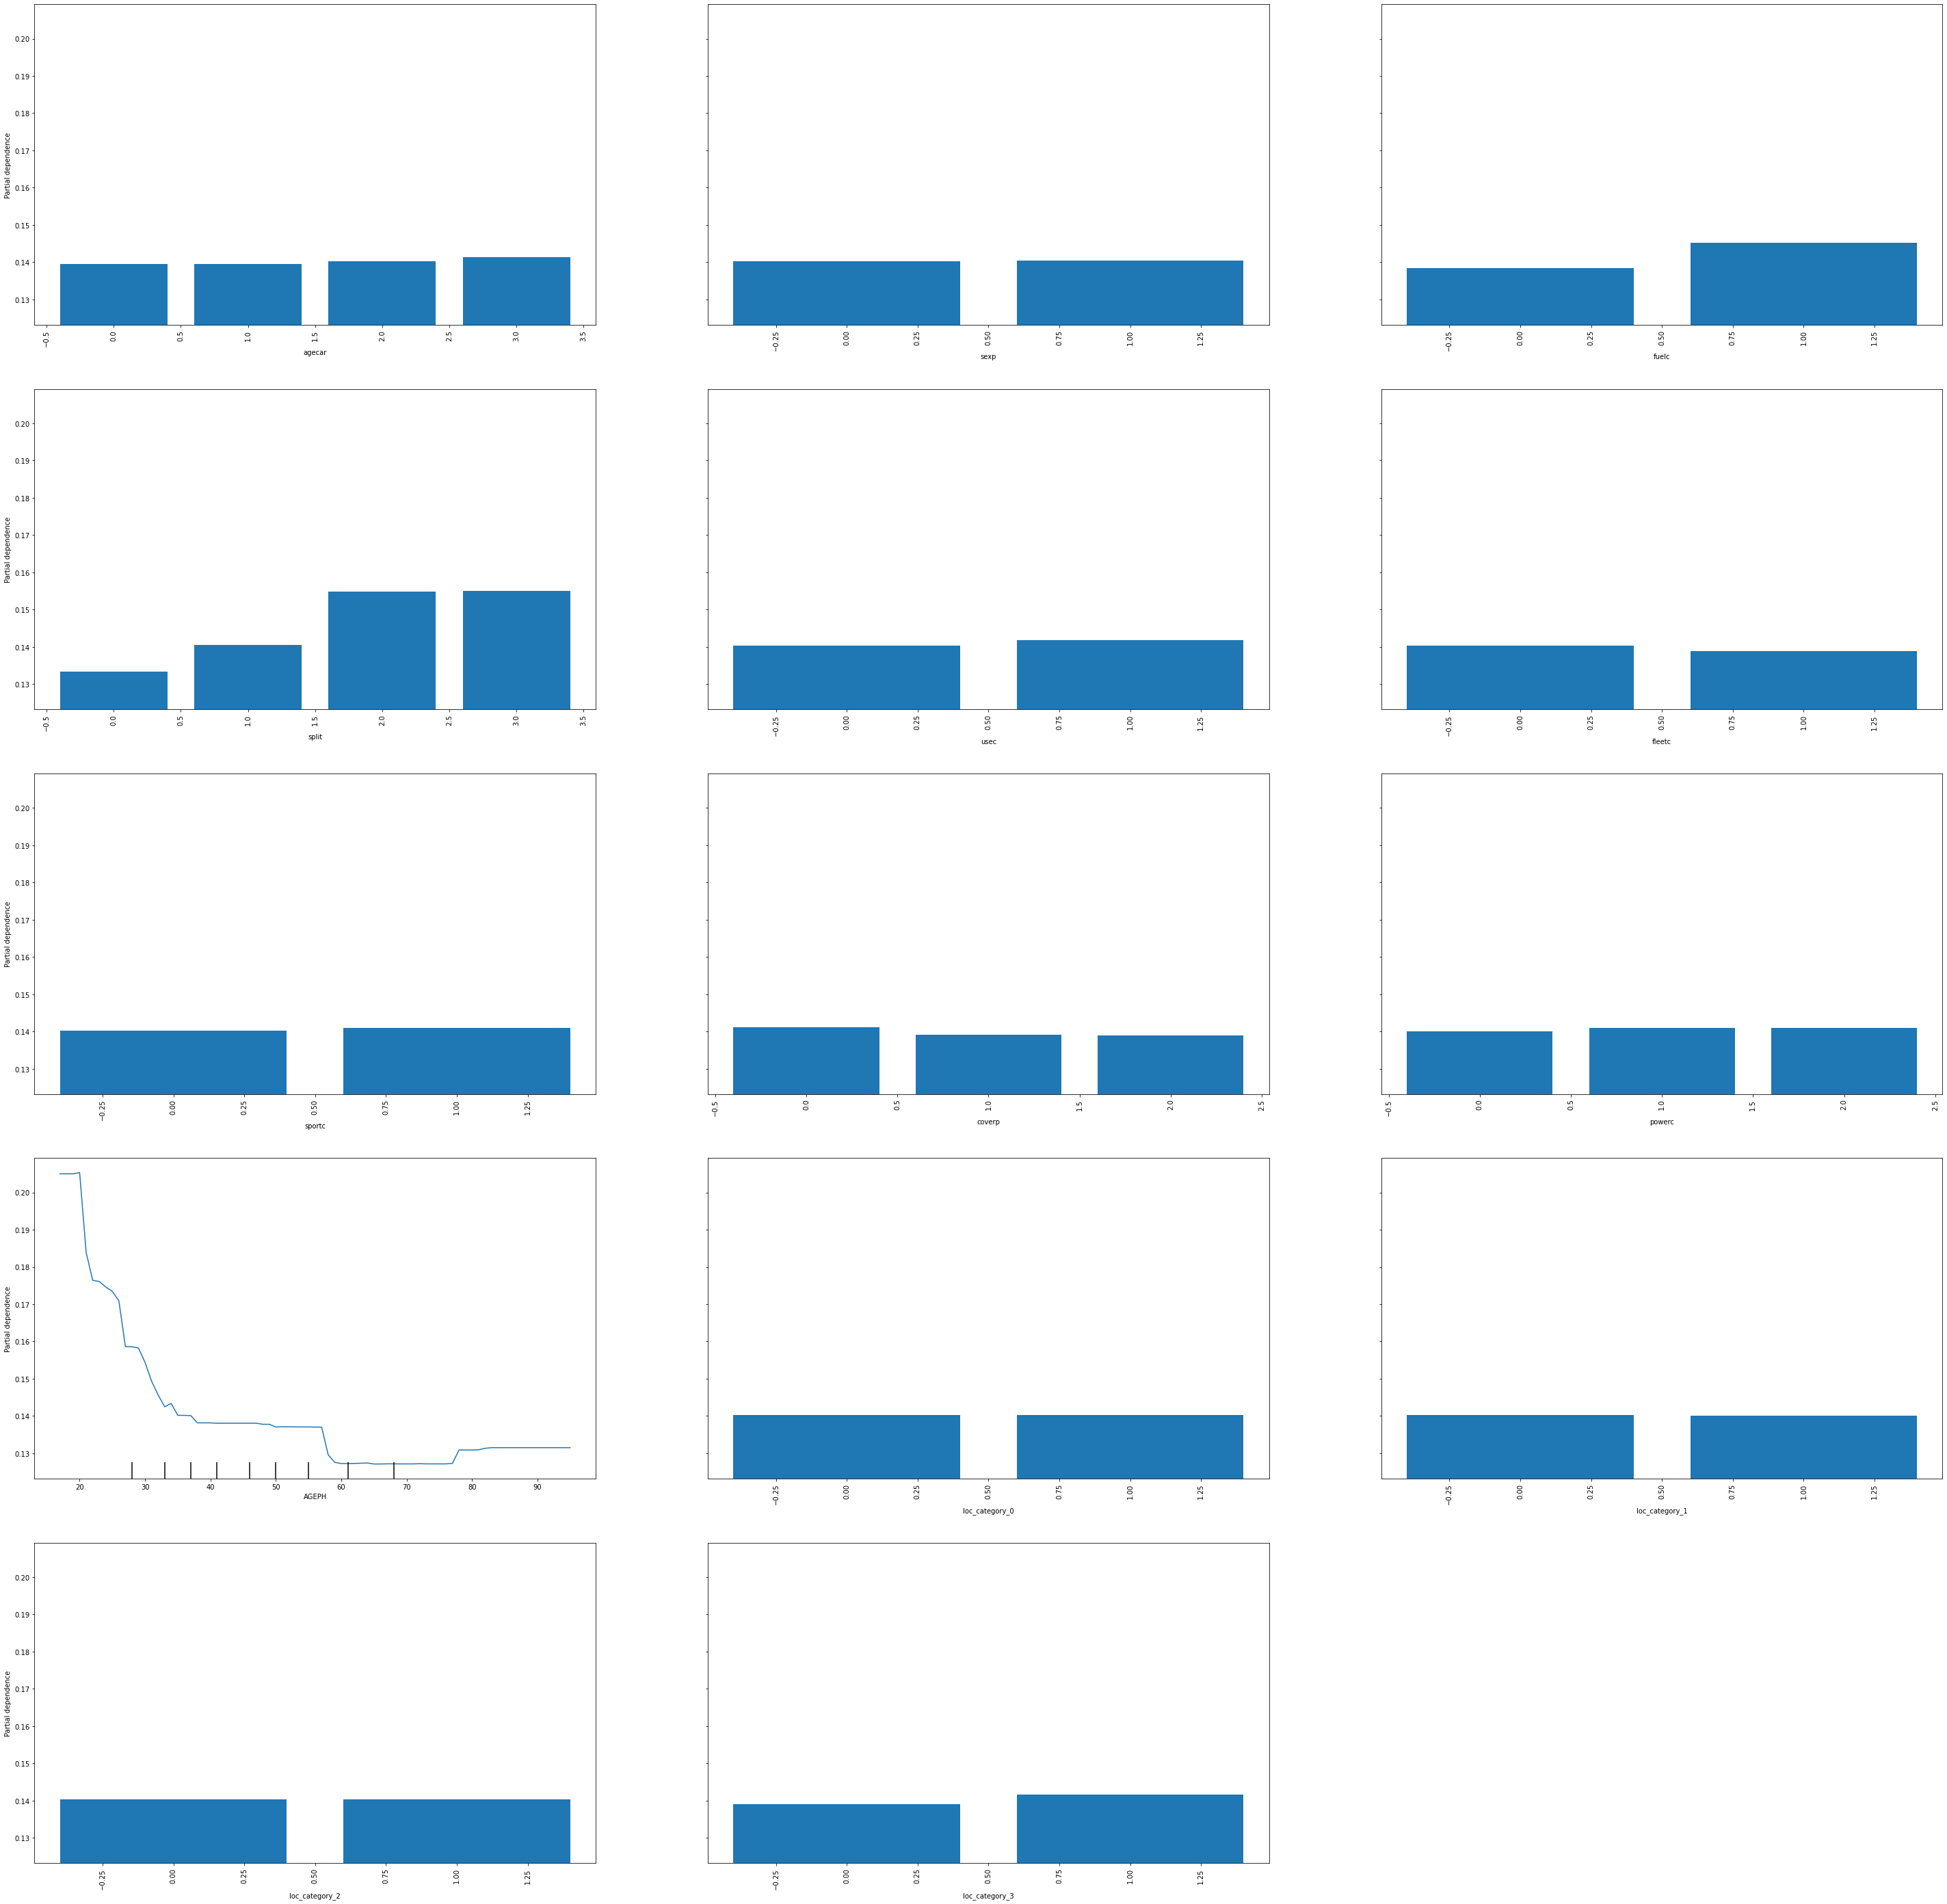

<Figure size 10800x10800 with 0 Axes>

In [17]:
fig, ax = plt.subplots(figsize=(50, 50))
plt.figure(figsize=(150, 150))
PartialDependenceDisplay.from_estimator(xgb_freq, X_freq_train, 
                                        features =feat_cols, 
                                        categorical_features= categorical_feat_cols,
                                        kind='average', ax=ax)

### 3.2 Severity preidction

In [18]:
tmp = pd.concat([X_train, y_train], axis=1)
tmp = tmp[tmp['nbrtotc'] > 1]

X_sev_train = tmp[X_train.columns]
y_sev_train = tmp['chargtot'] / tmp['nbrtotc']
y_sev_log_train = np.log(y_sev_train)
w_sev_train = tmp['nbrtotc']

#### 3.2.1 Mode building

In [19]:
xgb_init_sev = xgb.XGBRegressor(booster='gbtree',
                            learning_rate = 0.01,
                            objective='reg:gamma',
                            eval_metric = 'gamma-nloglik',
                            monotone_constraints = (1,0,0,0,0,0,0,0,0),
                            base_score = np.sum(y_sev_train * w_sev_train)/np.sum(w_sev_train))

In [20]:
%time 

xgb_randomsearch_sev = RandomizedSearchCV(estimator=xgb_init_sev,
                                      param_distributions=param_dict_xgb,
                                      scoring='neg_mean_gamma_deviance',
                                      n_iter=2,
                                      verbose=1,
                                      cv=5,
                                      random_state = 54321)
xgb_randomsearch_sev.fit(X_sev_train, y_sev_train, sample_weight=w_sev_train)

CPU times: total: 0 ns
Wall time: 0 ns
Fitting 5 folds for each of 2 candidates, totalling 10 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=1513.2623052328586,
                                          booster='gbtree', callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric='gamma-nloglik',
                                          feature_types=None, gamma=None,
                                          gpu_id=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_co...
                                          monotone_constraints=(1, 0, 0, 0, 0,
                                                                0, 0, 0, 0),
                                          n_estimators=100, n_jobs=None,
                                          num_parallel_tree=None,
                                          objective='reg:gamma', predictor=None, ...),
                   n_iter=2,
                   param_distributions={'alpha': [0, 0.1, 1],
                                        'colsample_bynode': [0.5, 0.75, 1],
                                        'lambda': [0, 0.1, 1],
                                        'max_depth': [1, 3, 5, 7, 9],
                                        'n_estimators': [100, 200, 300]},
                   random_state=54321, scoring='neg_mean_gamma_deviance',
                   verbose=1)

In [21]:
xgb_sev = xgb_randomsearch_sev.best_estimator_

#### 3.2.2 Interpretation

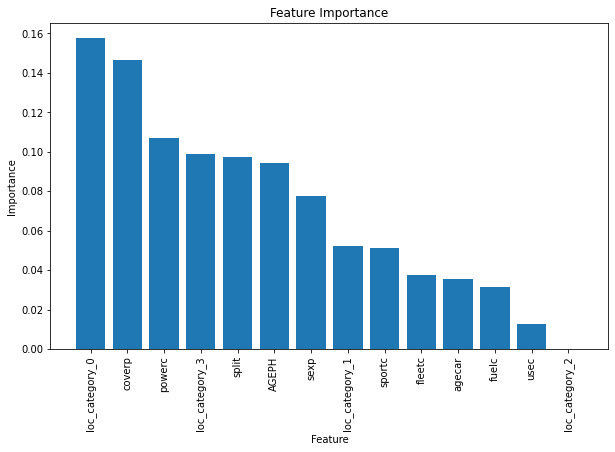

,feature,importance
10,loc_category_0,0.157415
7,coverp,0.146599
8,powerc,0.106772
13,loc_category_3,0.099007
3,split,0.097520
9,AGEPH,0.094284
1,sexp,0.077564
11,loc_category_1,0.052103
6,sportc,0.051095
5,fleetc,0.037671


In [22]:
get_feat_importance(xgb_sev, X_sev_train)

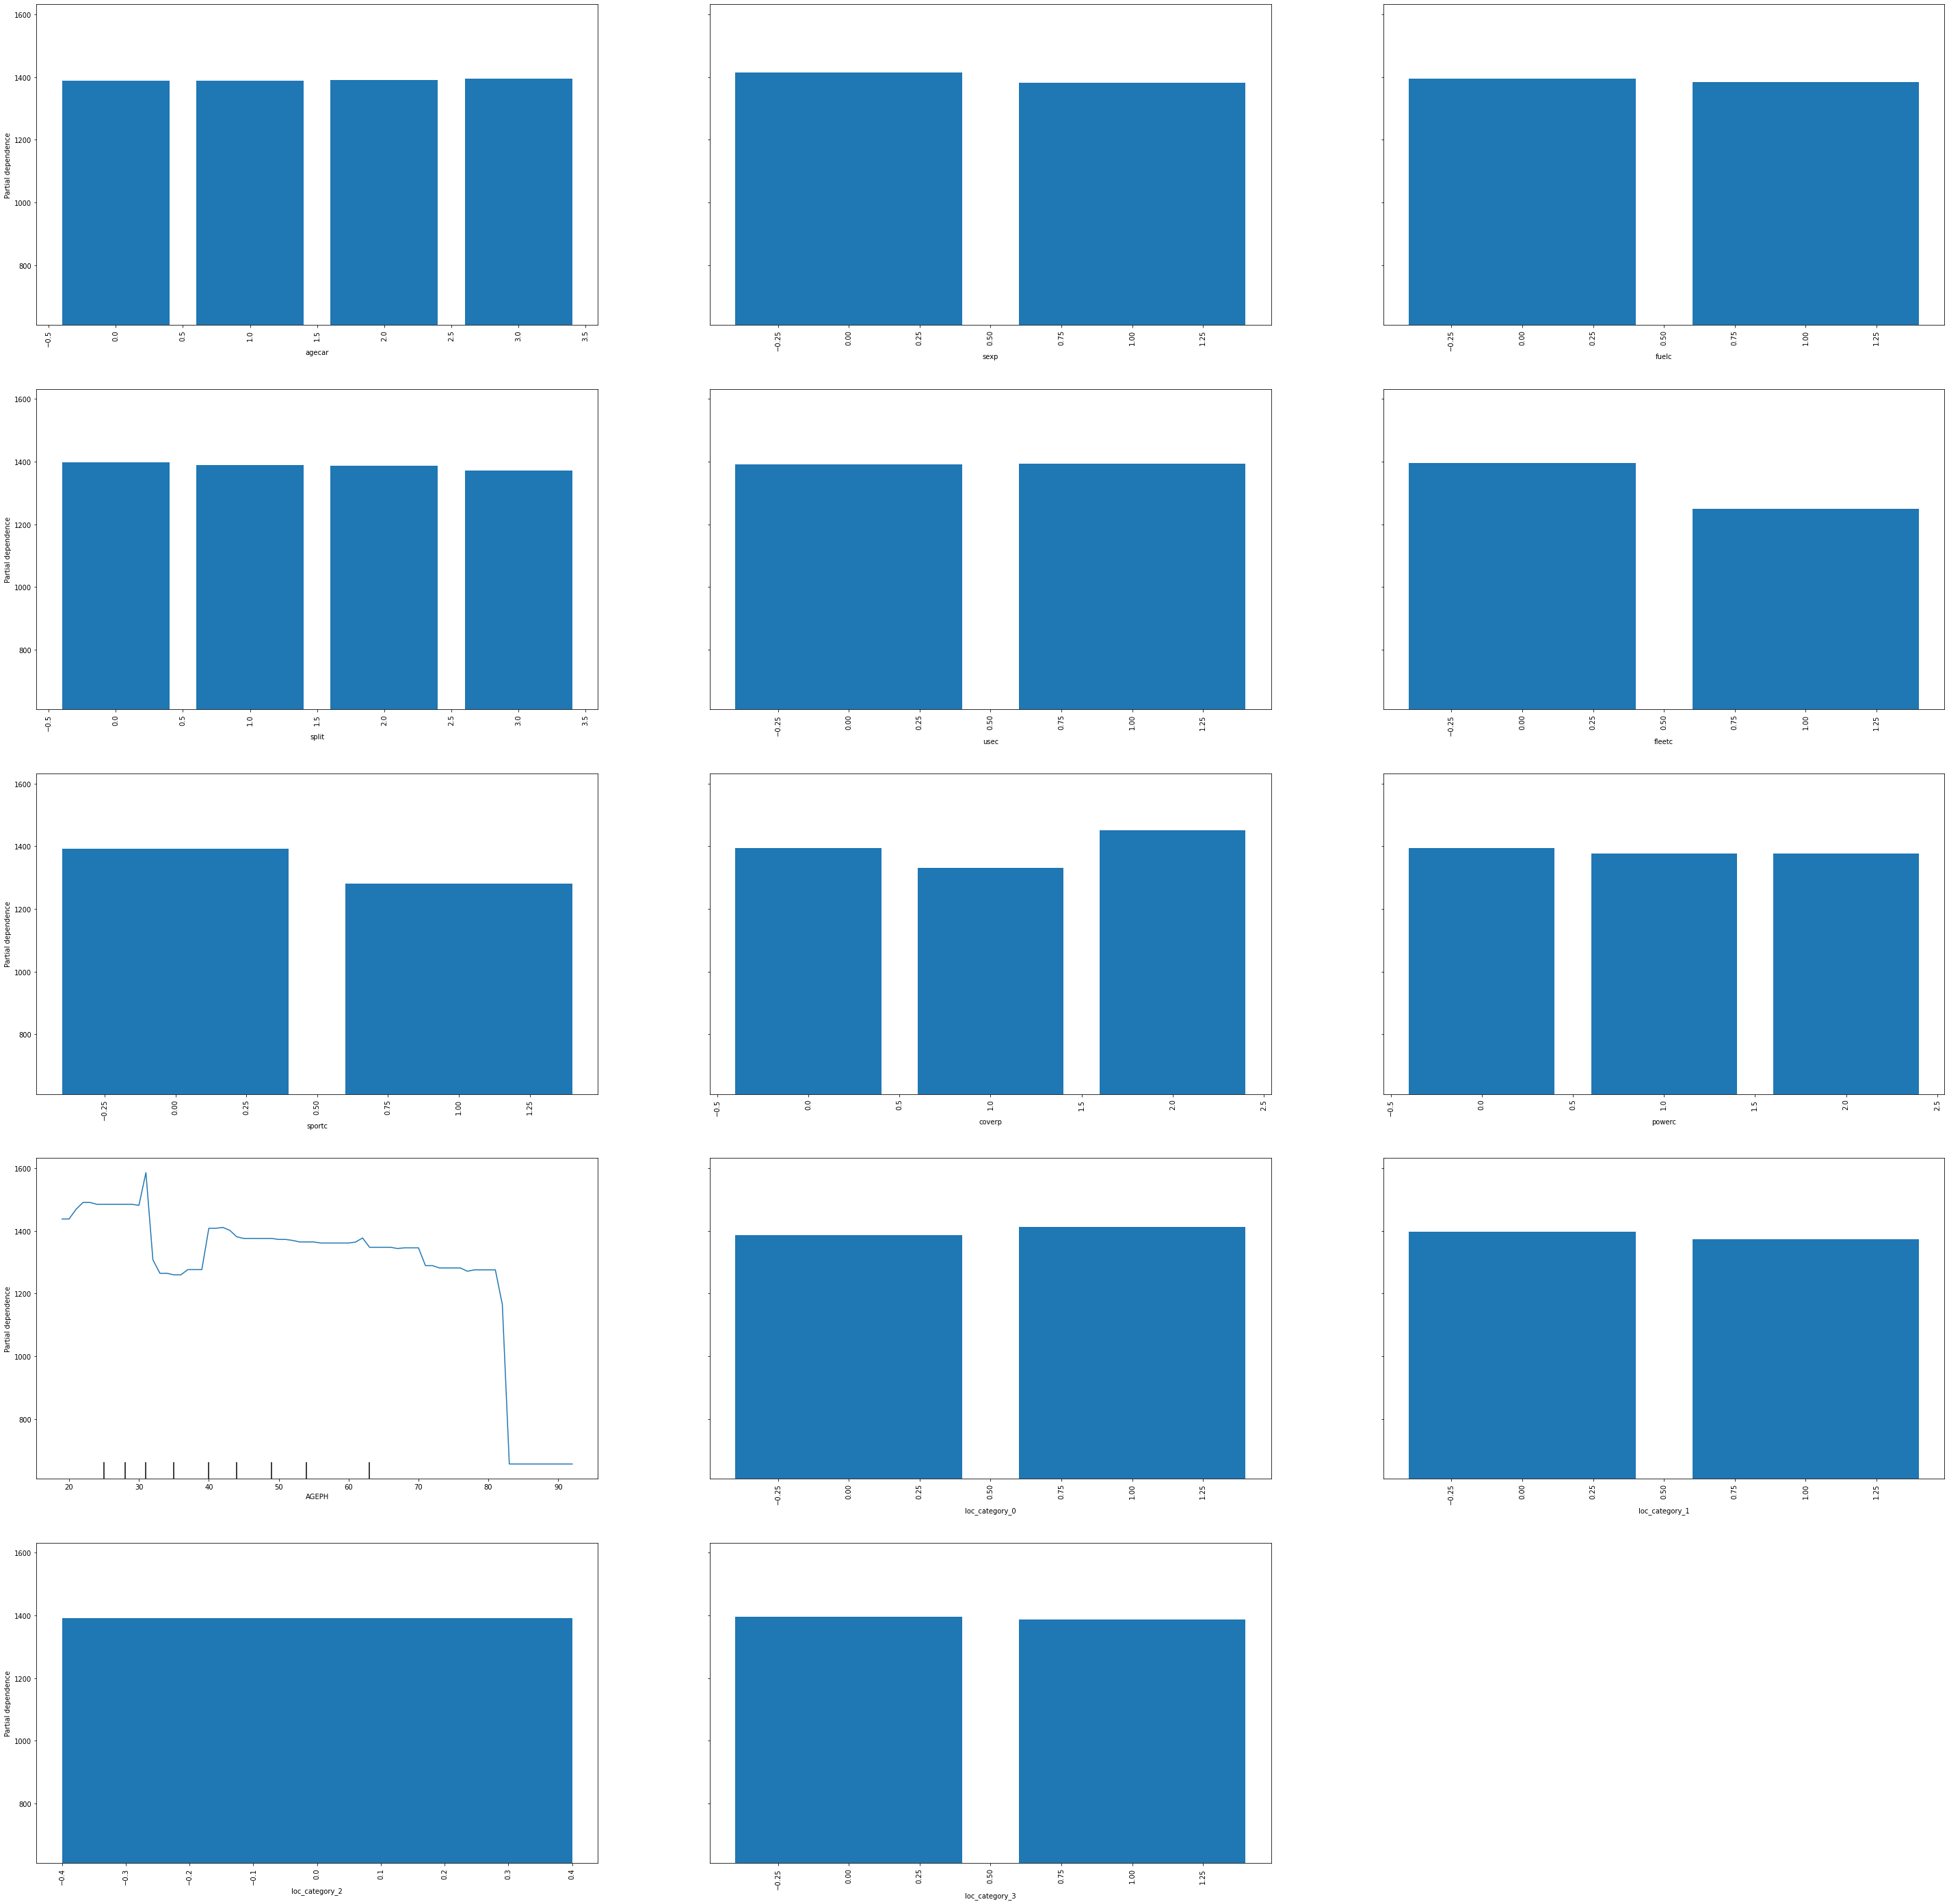

<Figure size 10800x10800 with 0 Axes>

In [23]:
fig, ax = plt.subplots(figsize=(50, 50))
plt.figure(figsize=(150, 150))
PartialDependenceDisplay.from_estimator(xgb_sev, X_sev_train, 
                                        features =feat_cols, 
                                        categorical_features= categorical_feat_cols,
                                        kind='average', ax=ax)

### 3.3 Caluclations safety demonstration

In [24]:
total_loss = y_test['chargtot'].sum()
exposure = y_test['expo']


In [25]:
xbg_pred_freq = xgb_freq.predict(X_test)
xbg_pred_sev = xgb_sev.predict(X_test)#tmp['chargtot'] / tmp['nbrtotc']

xgb_tech_premium = xbg_pred_freq * xbg_pred_sev

total_loss / sum(xgb_tech_premium * exposure)

1.158561667892167

## 4 Random forest

### 4.1 Frequency prediction

In [26]:
param_dict_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf_init_freq = RandomForestRegressor(random_state=42)

In [ ]:
%time

rf_randomsearch_freq = RandomizedSearchCV(estimator=rf_init_freq,
                                      param_distributions=param_dict_rf,
                                     scoring='neg_mean_poisson_deviance',
                                      n_iter=2,
                                      verbose=1,
                                      cv=5,
                                      random_state = 54321)
rf_randomsearch_freq.fit(X_freq_train, y_freq_train, sample_weight=w_freq_train)

CPU times: total: 0 ns
Wall time: 0 ns
Fitting 5 folds for each of 2 candidates, totalling 10 fits


In [ ]:
rf_freq = rf_randomsearch_freq.best_estimator_

#### 4.1.2 Interpretation

In [ ]:
get_feat_importance(rf_freq, X_freq_train)

In [ ]:
fig, ax = plt.subplots(figsize=(50, 50))
plt.figure(figsize=(150, 150))
PartialDependenceDisplay.from_estimator(rf_freq, X_freq_train, 
                                        features =feat_cols, 
                                        categorical_features= categorical_feat_cols,
                                        kind='average', ax=ax)

### 4.2 Severity preidction

In [ ]:
rf_init_sev = RandomForestRegressor(random_state=42)

In [ ]:
%time 

rf_randomsearch_sev = RandomizedSearchCV(estimator=rf_init_sev,
                                      param_distributions=param_dict_rf,
                                     scoring='neg_mean_gamma_deviance',
                                      n_iter=2,
                                      verbose=1,
                                      cv=5,
                                      random_state = 54321)
rf_randomsearch_sev.fit(X_sev_train, y_sev_train, sample_weight=w_sev_train)

In [ ]:
rf_sev = rf_randomsearch_sev.best_estimator_

#### 4.2.2 Interpretation

In [ ]:
get_feat_importance(rf_sev, X_sev_train)

In [ ]:
fig, ax = plt.subplots(figsize=(50, 50))
plt.figure(figsize=(150, 150))
PartialDependenceDisplay.from_estimator(rf_sev, X_sev_train, 
                                        features =feat_cols, 
                                        categorical_features= categorical_feat_cols,
                                        kind='average', ax=ax)

### 4.4 Caluclation safety demonstration

In [ ]:
rf_pred_freq = rf_freq.predict(X_test)
rf_pred_sev = rf_sev.predict(X_test)#tmp['chargtot'] / tmp['nbrtotc']

rf_tech_premium = rf_pred_freq * rf_pred_sev

total_loss / sum(rf_tech_premium * exposure)

In [ ]:
%time